4.	Soil erosion detection

Here is one of the open problems in Quantum. Soil erosion is a really unwanted process that spoils huge areas of fertile land. Your task is to train model for erosion detection.

What do you have

●	Sentinel2 tile (T36UXV_20200406T083559_TCI_10m.jp2);<br>
●	Masks with soil erosion for this tile (masks directory);


In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

### Reading Raster with rasterio

In [2]:
raster_path = "../T36UXV_20200406T083559_TCI_10m.jp2"

with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta


Checking Raster shape and Meta

In [3]:
print(raster_img.shape)


(3, 10980, 10980)


In [4]:
raster_meta


{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

Using rasterio reshape to plot an image in matplotlib

In [5]:
raster_img = reshape_as_image(raster_img)


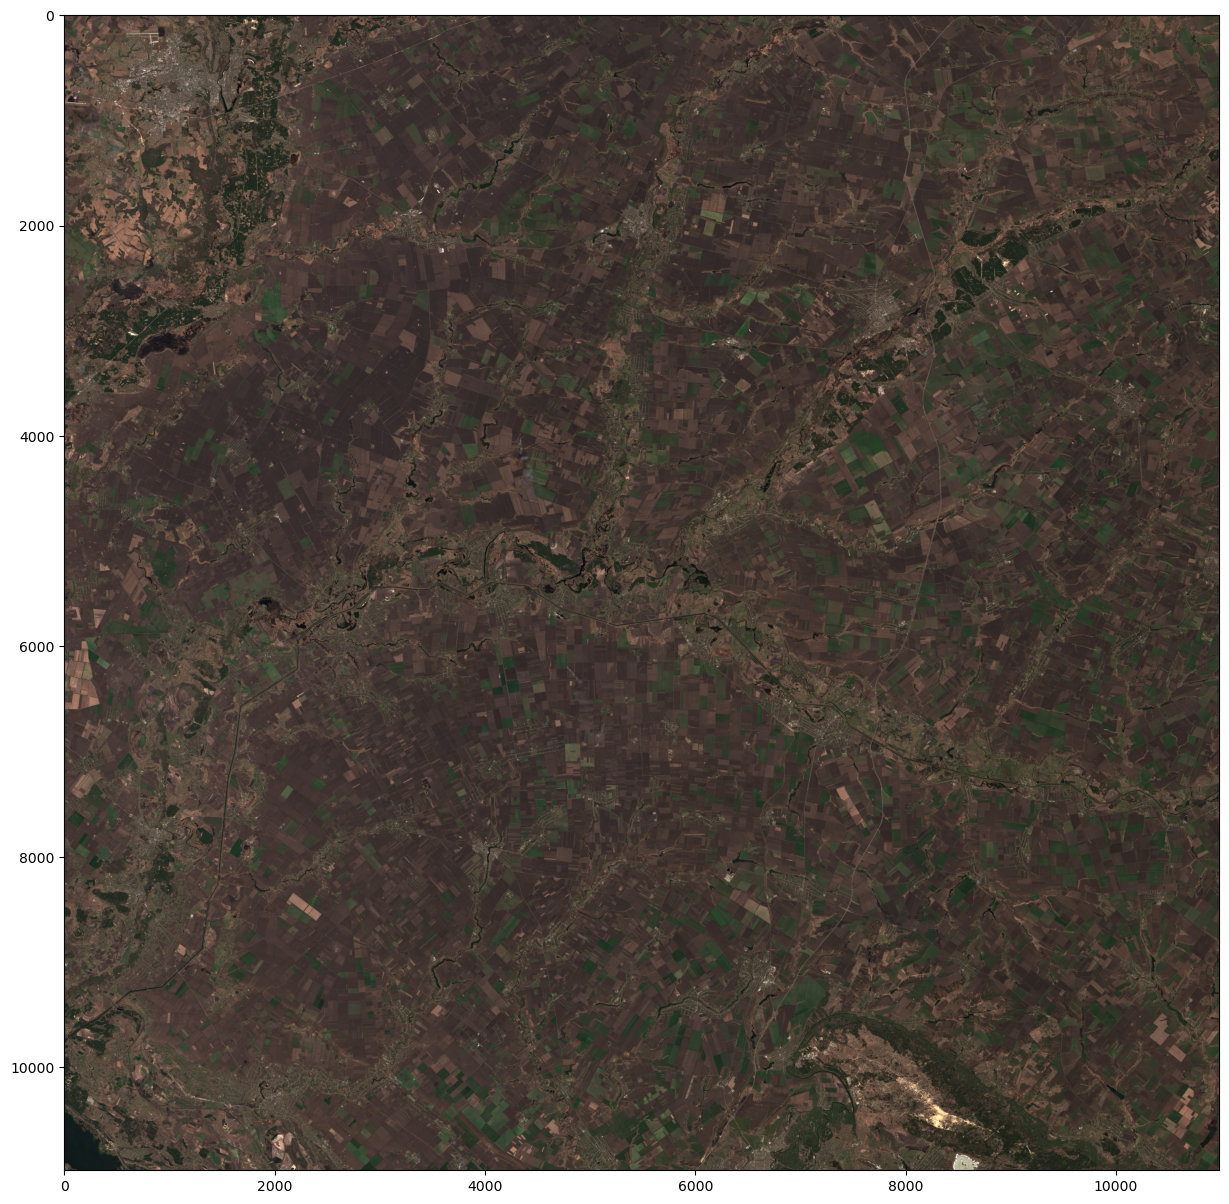

In [6]:
plt.figure(figsize=(15, 15))
plt.imshow(raster_img)


Reading train labels with GeoPandas

In [7]:
train_df = gpd.read_file("../masks/Masks_T36UXV_20190427.shp")
print(len(train_df))
train_df.head(5)


936


id  Data  Code       Descriptio Comments                   Image  \
0 NaN   NaN   2.0   branch of tree      NaN  T36UXV_20190427T083601   
1 NaN   NaN   1.0  color+ feathers      NaN  T36UXV_20190427T083601   
2 NaN   NaN   2.0   brahch of tree      NaN  T36UXV_20190427T083601   
3 NaN   NaN   1.0  color+ feathers      NaN  T36UXV_20190427T083601   
4 NaN   NaN   1.0  color+ feathers      NaN  T36UXV_20190427T083601   

                                            geometry  
0  POLYGON ((35.62916 49.60293, 35.63015 49.60163...  
1  POLYGON ((35.65070 49.60254, 35.65248 49.60301...  
2  POLYGON ((35.63023 49.60826, 35.62960 49.60920...  
3  POLYGON ((35.62033 49.60905, 35.62064 49.60968...  
4  POLYGON ((35.60455 49.61078, 35.60597 49.61228...

Checking coordinates of polygon using Polygon methods

In [8]:
train_df["geometry"][0].exterior.coords.xy


(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

### Creating binary mask

Trying to cut fields from Raster

In [9]:
src = rasterio.open(raster_path, "r")
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(
            src, [mapping(row["geometry"])], crop=True, nodata=0
        )
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))


Rasterio failed to mask 936 files


Converting GeoDataframe to raster CRS

In [10]:
train_df = gpd.read_file("../masks/Masks_T36UXV_20190427.shp")

# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# assigning crs
train_df.crs = {"init": "epsg:4284"}

# transforming polygons to the raster crs
train_df = train_df.to_crs({"init": raster_meta["crs"]["init"]})


c:\Users\Stepan\anaconda3\envs\quantum\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Preparing binary mask

C:\Users\Stepan\AppData\Local\Temp\ipykernel_2508\1525746356.py:8: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


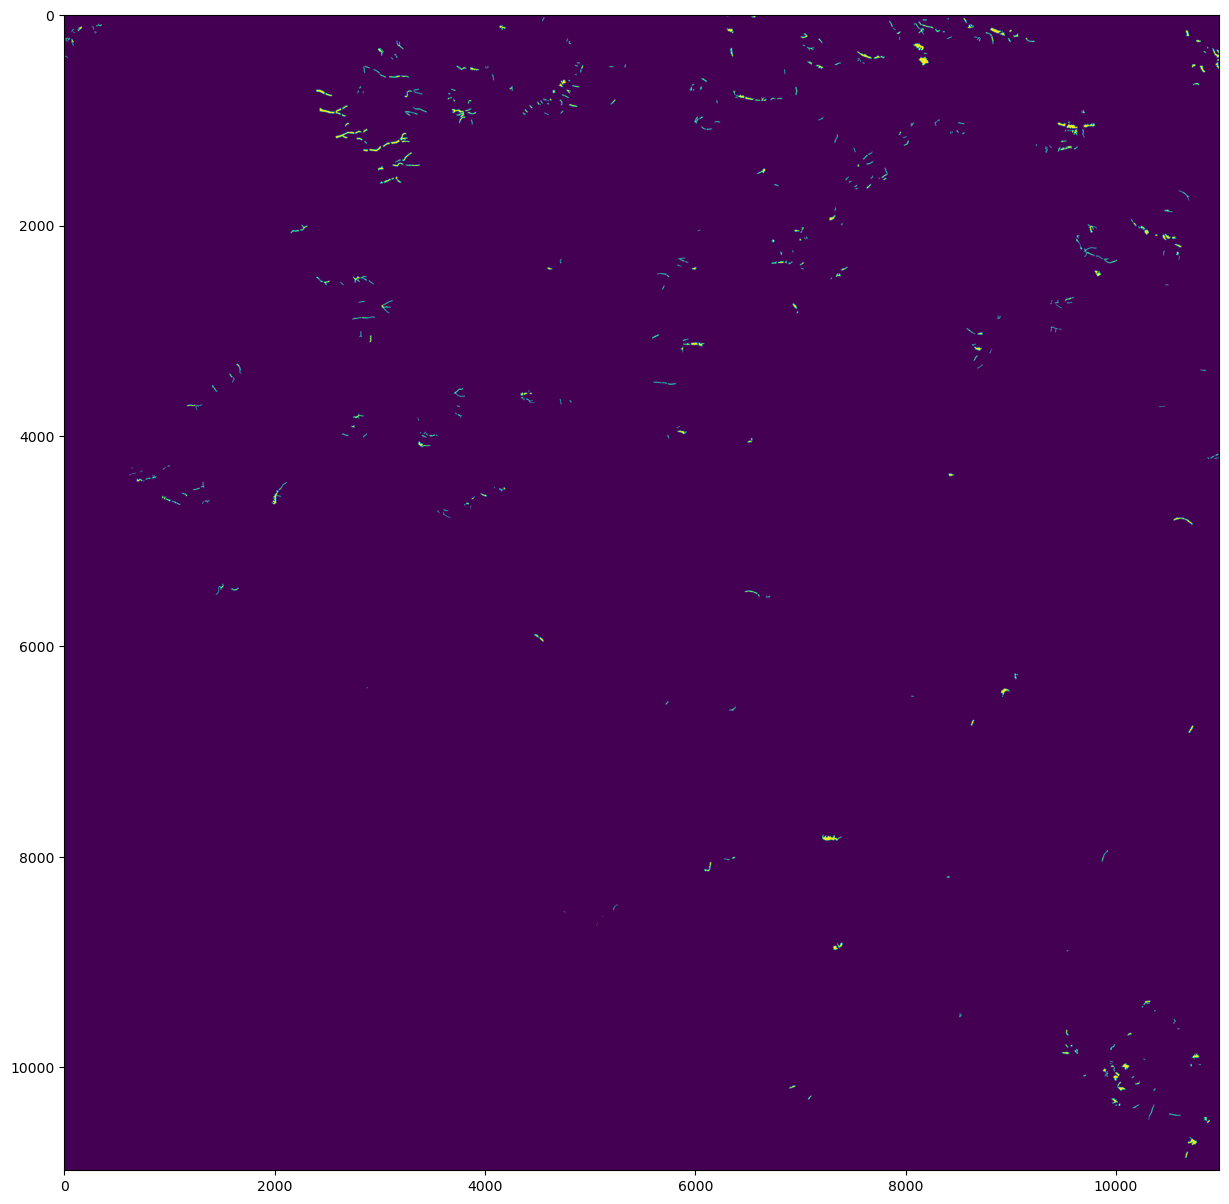

In [11]:
# rasterize works with polygons that are in image coordinate system
src = rasterio.open(raster_path, "r", driver="JP2OpenJPEG")


def poly_from_utm(polygon, transform):
    poly_pts = []

    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))

    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly


# creating binary mask for field/not_filed segmentation.
poly_shp = []
im_size = (src.meta["height"], src.meta["width"])
for num, row in train_df.iterrows():
    if row["geometry"].geom_type == "Polygon":
        poly = poly_from_utm(row["geometry"], src.meta["transform"])
        poly_shp.append(poly)
    else:
        for p in row["geometry"]:
            poly = poly_from_utm(p, src.meta["transform"])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp, out_shape=im_size)

# plotting the mask
plt.figure(figsize=(15, 15))
plt.imshow(mask)


### Preparing image for model training

Split image on tiles

In [12]:
def split_image(image3, tile_size):
    image_shape = tf.shape(image3)
    tile_rows = tf.reshape(image3, [image_shape[0], -1, tile_size[1], image_shape[2]])
    serial_tiles = tf.transpose(tile_rows, [1, 0, 2, 3])
    return tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0], image_shape[2]])


In [13]:
def unsplit_image(tiles4, image_shape):
    tile_width = tf.shape(tiles4)[1]
    serialized_tiles = tf.reshape(
        tiles4, [-1, image_shape[0], tile_width, image_shape[2]]
    )
    rowwise_tiles = tf.transpose(serialized_tiles, [1, 0, 2, 3])
    return tf.reshape(rowwise_tiles, [image_shape[0], image_shape[1], image_shape[2]])


In [14]:
def pad_image_to_tile_multiple(image3, tile_size, padding="CONSTANT"):
    imagesize = tf.shape(image3)[0:2]
    padding_ = (
        tf.cast(tf.math.ceil(imagesize / tile_size), tf.int32) * tile_size - imagesize
    )
    return tf.pad(image3, [[0, padding_[0]], [0, padding_[1]], [0, 0]], padding)


In [15]:
raster_img.shape


(10980, 10980, 3)

In [16]:
mask.shape


(10980, 10980)

In [17]:
full_image = np.expand_dims(raster_img, axis=0)


In [18]:
full_mask = tf.expand_dims(mask, axis=2)  # add color dimention
# full_mask = tf.expand_dims(full_mask, axis=0)   # add batch dimention


In [19]:
full_mask.shape


TensorShape([10980, 10980, 1])

In [20]:
tile_size = (180, 180)
pad_image = pad_image_to_tile_multiple(raster_img, tile_size, padding="CONSTANT")
pad_mask = pad_image_to_tile_multiple(full_mask, tile_size, padding="CONSTANT")

image_tiles = split_image(pad_image, tile_size)
mask_tiles = split_image(pad_mask, tile_size)


In [21]:
image_tiles.shape


TensorShape([3721, 180, 180, 3])

In [22]:
mask_tiles.shape


TensorShape([3721, 180, 180, 1])

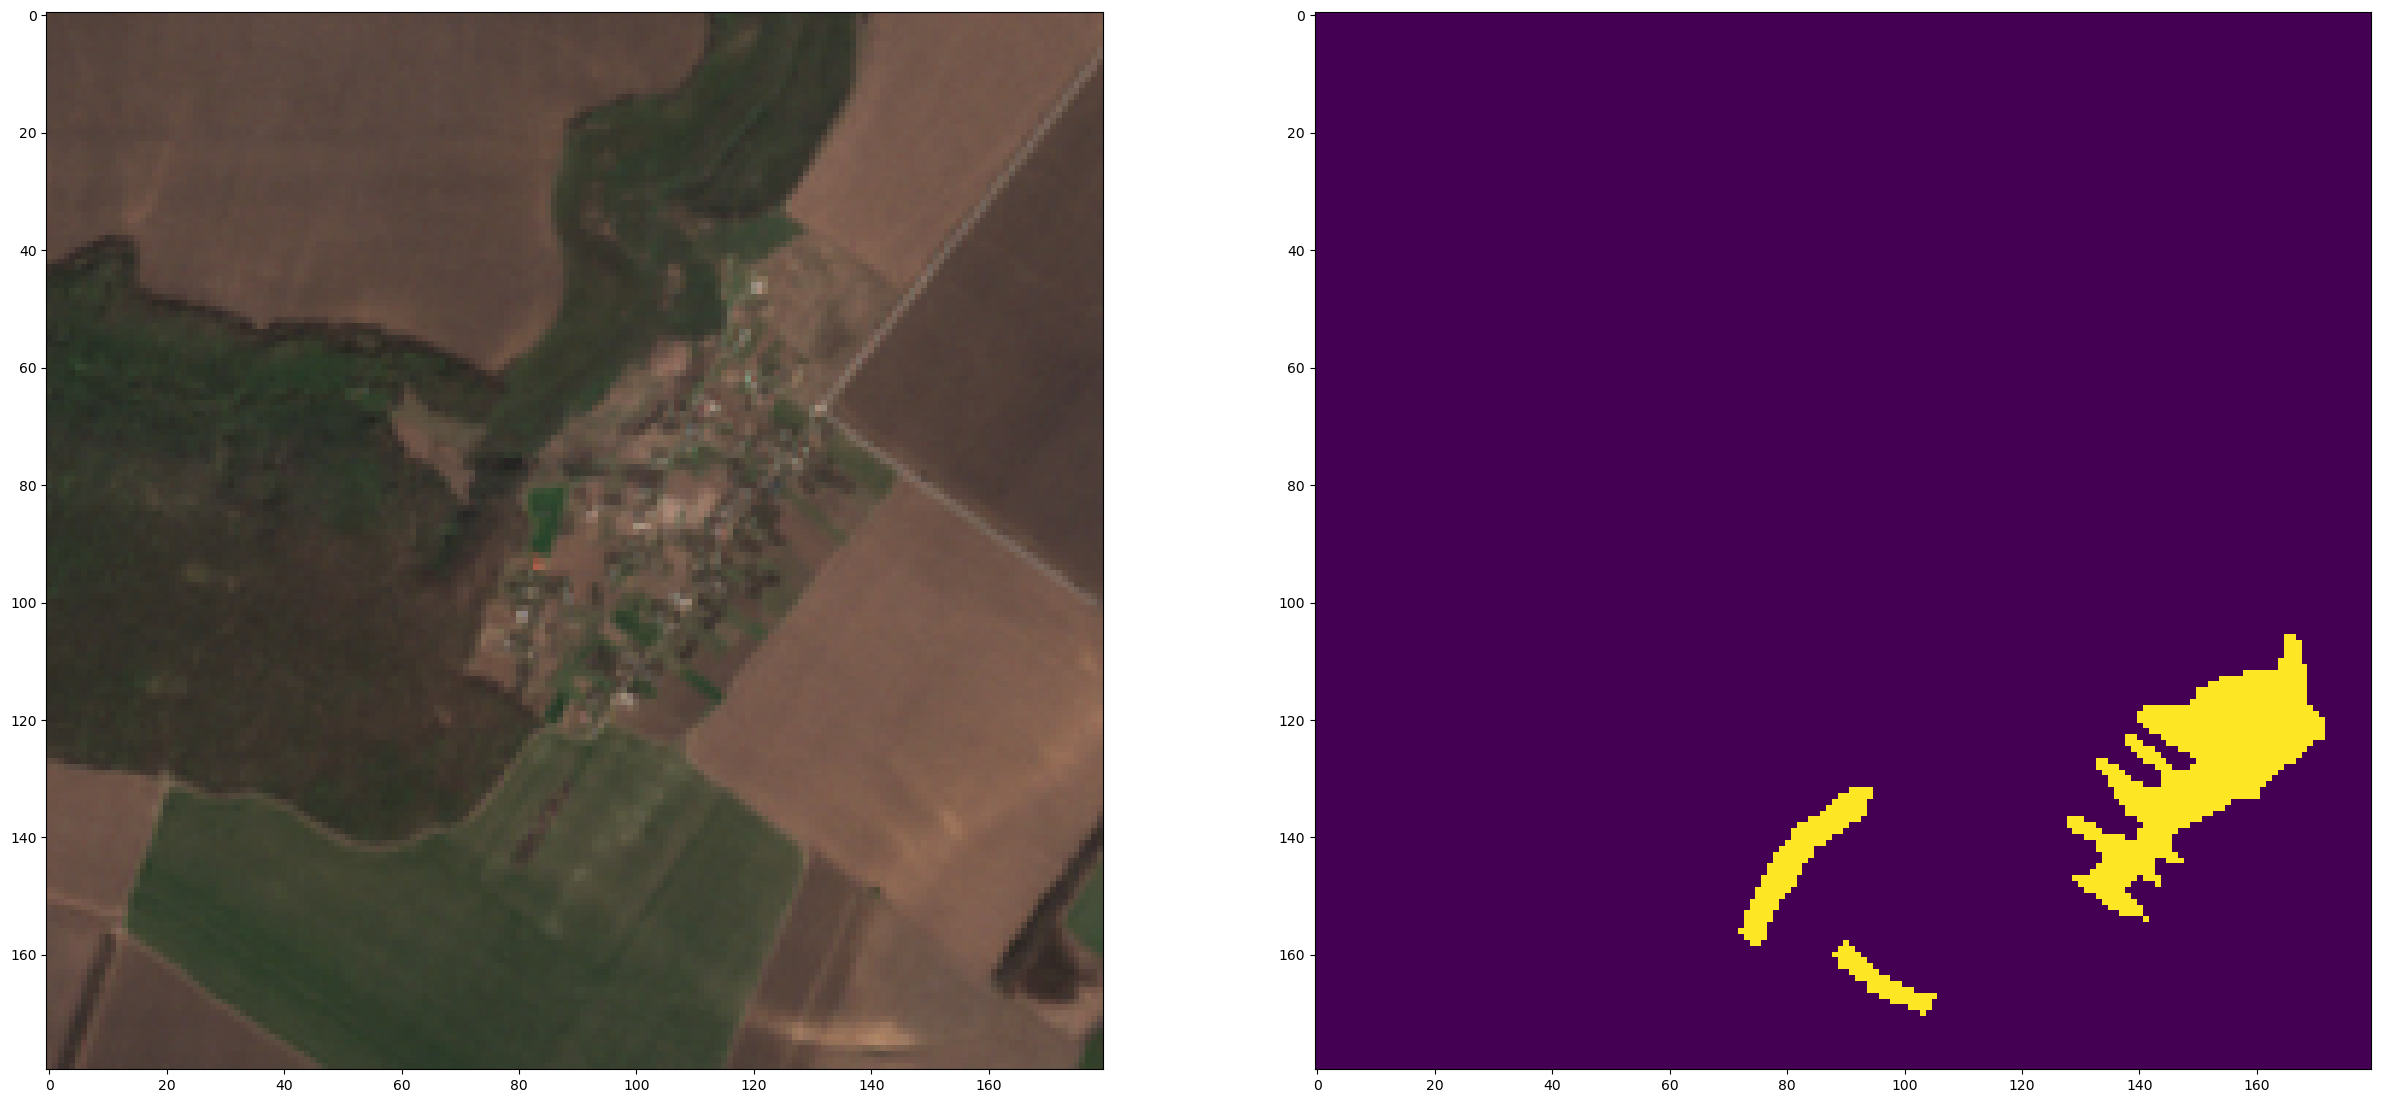

In [23]:
plt.figure(figsize=(30, 15))
plt.subplot(121)
plt.imshow(image_tiles[0, ...])
plt.subplot(122)
plt.imshow(mask_tiles[0, ...])


In [24]:
org_image = unsplit_image(image_tiles, tf.shape(pad_image))
org_image = org_image[0 : tf.shape(raster_img)[0], 0 : tf.shape(raster_img)[1], :]

org_mask = unsplit_image(mask_tiles, tf.shape(pad_mask))
org_mask = org_mask[0 : tf.shape(mask)[0], 0 : tf.shape(mask)[1], :]


In [25]:
org_image.shape


TensorShape([10980, 10980, 3])

In [26]:
org_mask.shape


TensorShape([10980, 10980, 1])

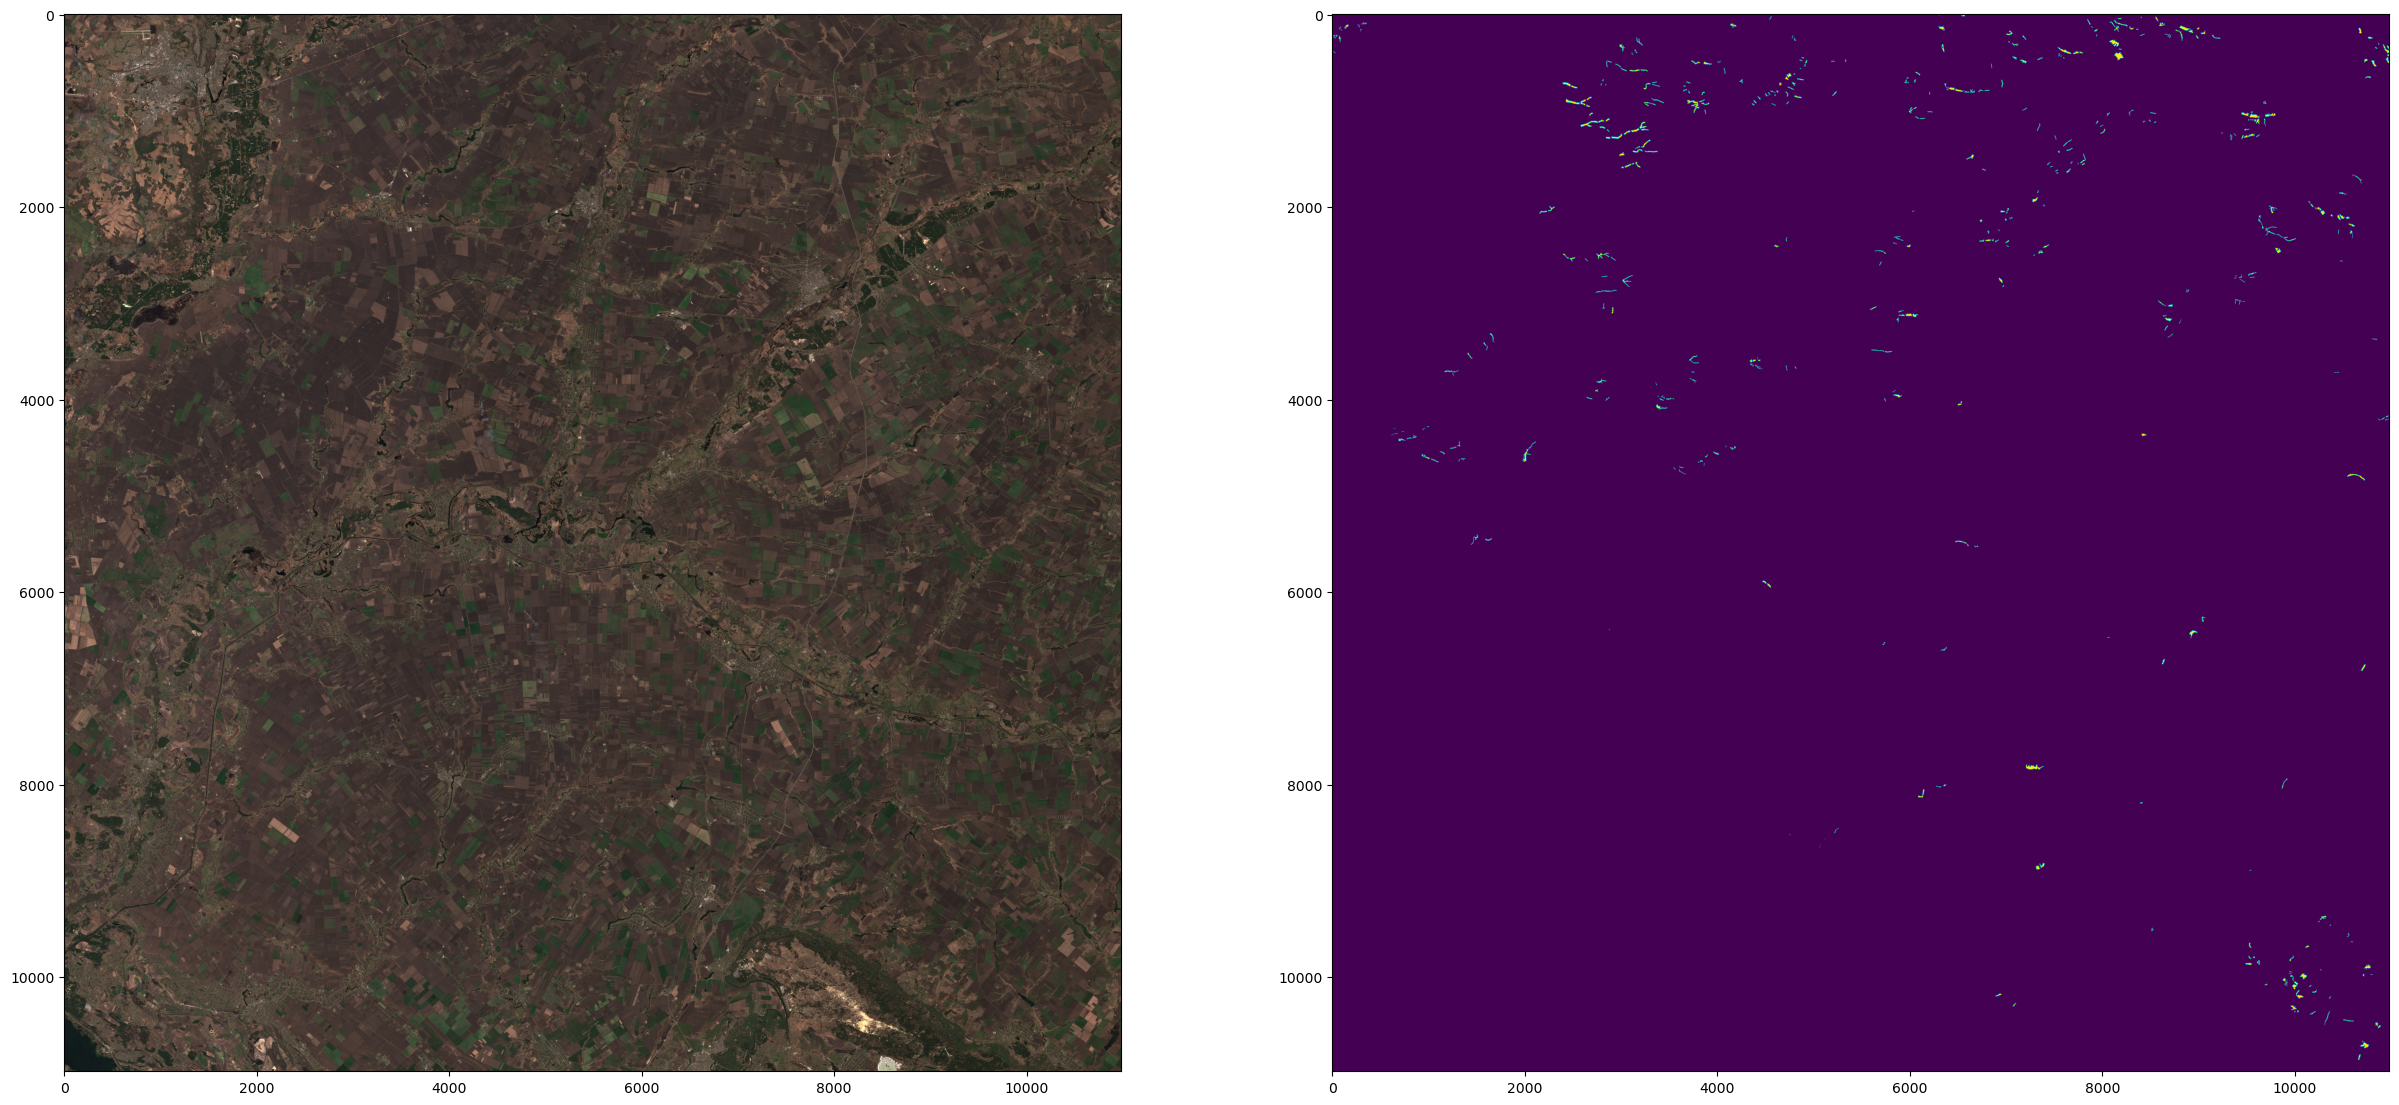

In [27]:
plt.figure(figsize=(30, 15))
plt.subplot(121)
plt.imshow(org_image)
plt.subplot(122)
plt.imshow(org_mask)


In [40]:
scaled_image = tf.keras.layers.Rescaling(scale=1 / 255)(image_tiles)

train_image, val_image = scaled_image[:3000], scaled_image[3000:]
train_mask, val_mask = mask_tiles[:3000], mask_tiles[3000:]


### Define the model

In [29]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(
    layers.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        activation="relu",
        input_shape=tf.shape(image_tiles)[1:],
        padding="same",
    )
)
model.add(
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")
)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")
)
model.add(
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")
)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")
)
model.add(
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")
)
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")
)
model.add(
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")
)
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")
)
model.add(
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same")
)
model.add(
    layers.Conv2D(
        filters=tf.shape(mask_tiles)[-1],
        kernel_size=(3, 3),
        activation="sigmoid",
        padding="same",
    )
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=tf.keras.metrics.BinaryAccuracy(),
)


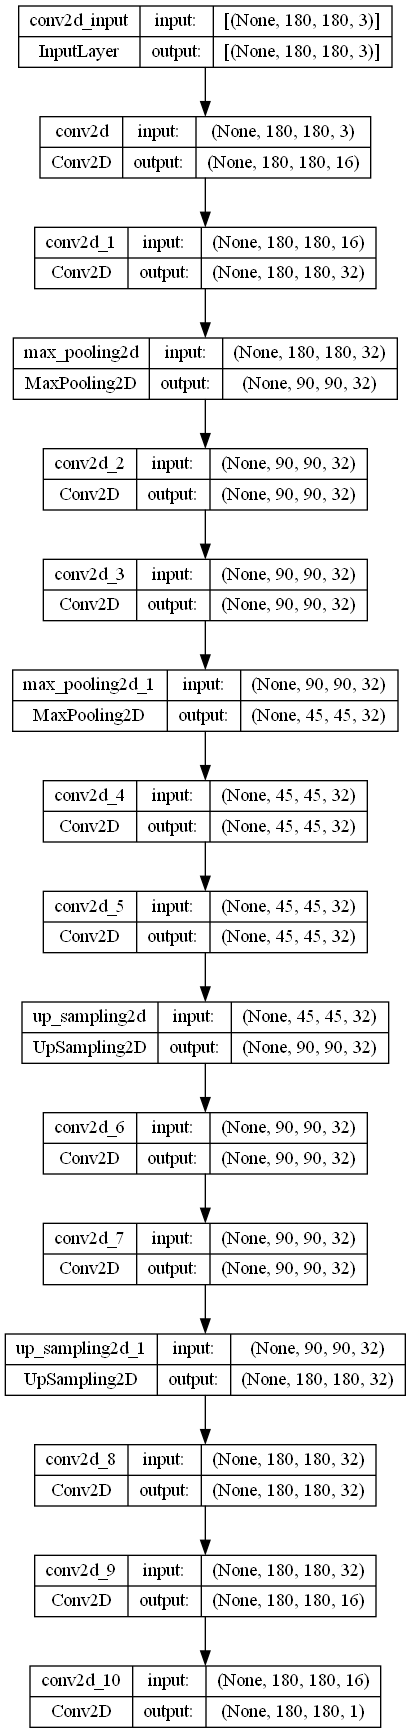

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)


### Train the model

Plot the resulting model architecture

In [32]:
history = model.fit(
    train_image, train_mask, epochs=5, validation_data=(val_image, val_mask)
)


Epoch 1/5
94/94 [==============================] - 388s 4s/step - loss: 0.0637 - binary_accuracy: 0.9980 - val_loss: 0.0232 - val_binary_accuracy: 0.9968
Epoch 2/5
94/94 [==============================] - 434s 5s/step - loss: 0.0147 - binary_accuracy: 0.9980 - val_loss: 0.0251 - val_binary_accuracy: 0.9968
Epoch 3/5
94/94 [==============================] - 373s 4s/step - loss: 0.0148 - binary_accuracy: 0.9980 - val_loss: 0.0230 - val_binary_accuracy: 0.9968
Epoch 4/5
94/94 [==============================] - 385s 4s/step - loss: 0.0144 - binary_accuracy: 0.9980 - val_loss: 0.0217 - val_binary_accuracy: 0.9968
Epoch 5/5
94/94 [==============================] - 370s 4s/step - loss: 0.0146 - binary_accuracy: 0.9980 - val_loss: 0.0243 - val_binary_accuracy: 0.9968


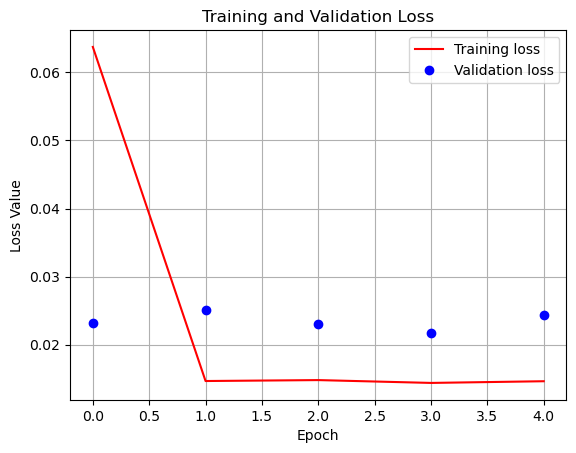

In [35]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure()
plt.plot(history.epoch, loss, "r", label="Training loss")
plt.plot(history.epoch, val_loss, "bo", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.grid()
plt.show()


In [41]:
predict_mask = model.predict(scaled_image)


117/117 [==============================] - 78s 664ms/step


Reshaping `predict_mask` tiles to original size image

In [52]:
full_predict_mask = unsplit_image(predict_mask, tf.shape(pad_mask))
full_predict_mask = full_predict_mask[0 : tf.shape(mask)[0], 0 : tf.shape(mask)[1], :]


Text(0.5, 1.0, 'Prediction musk')

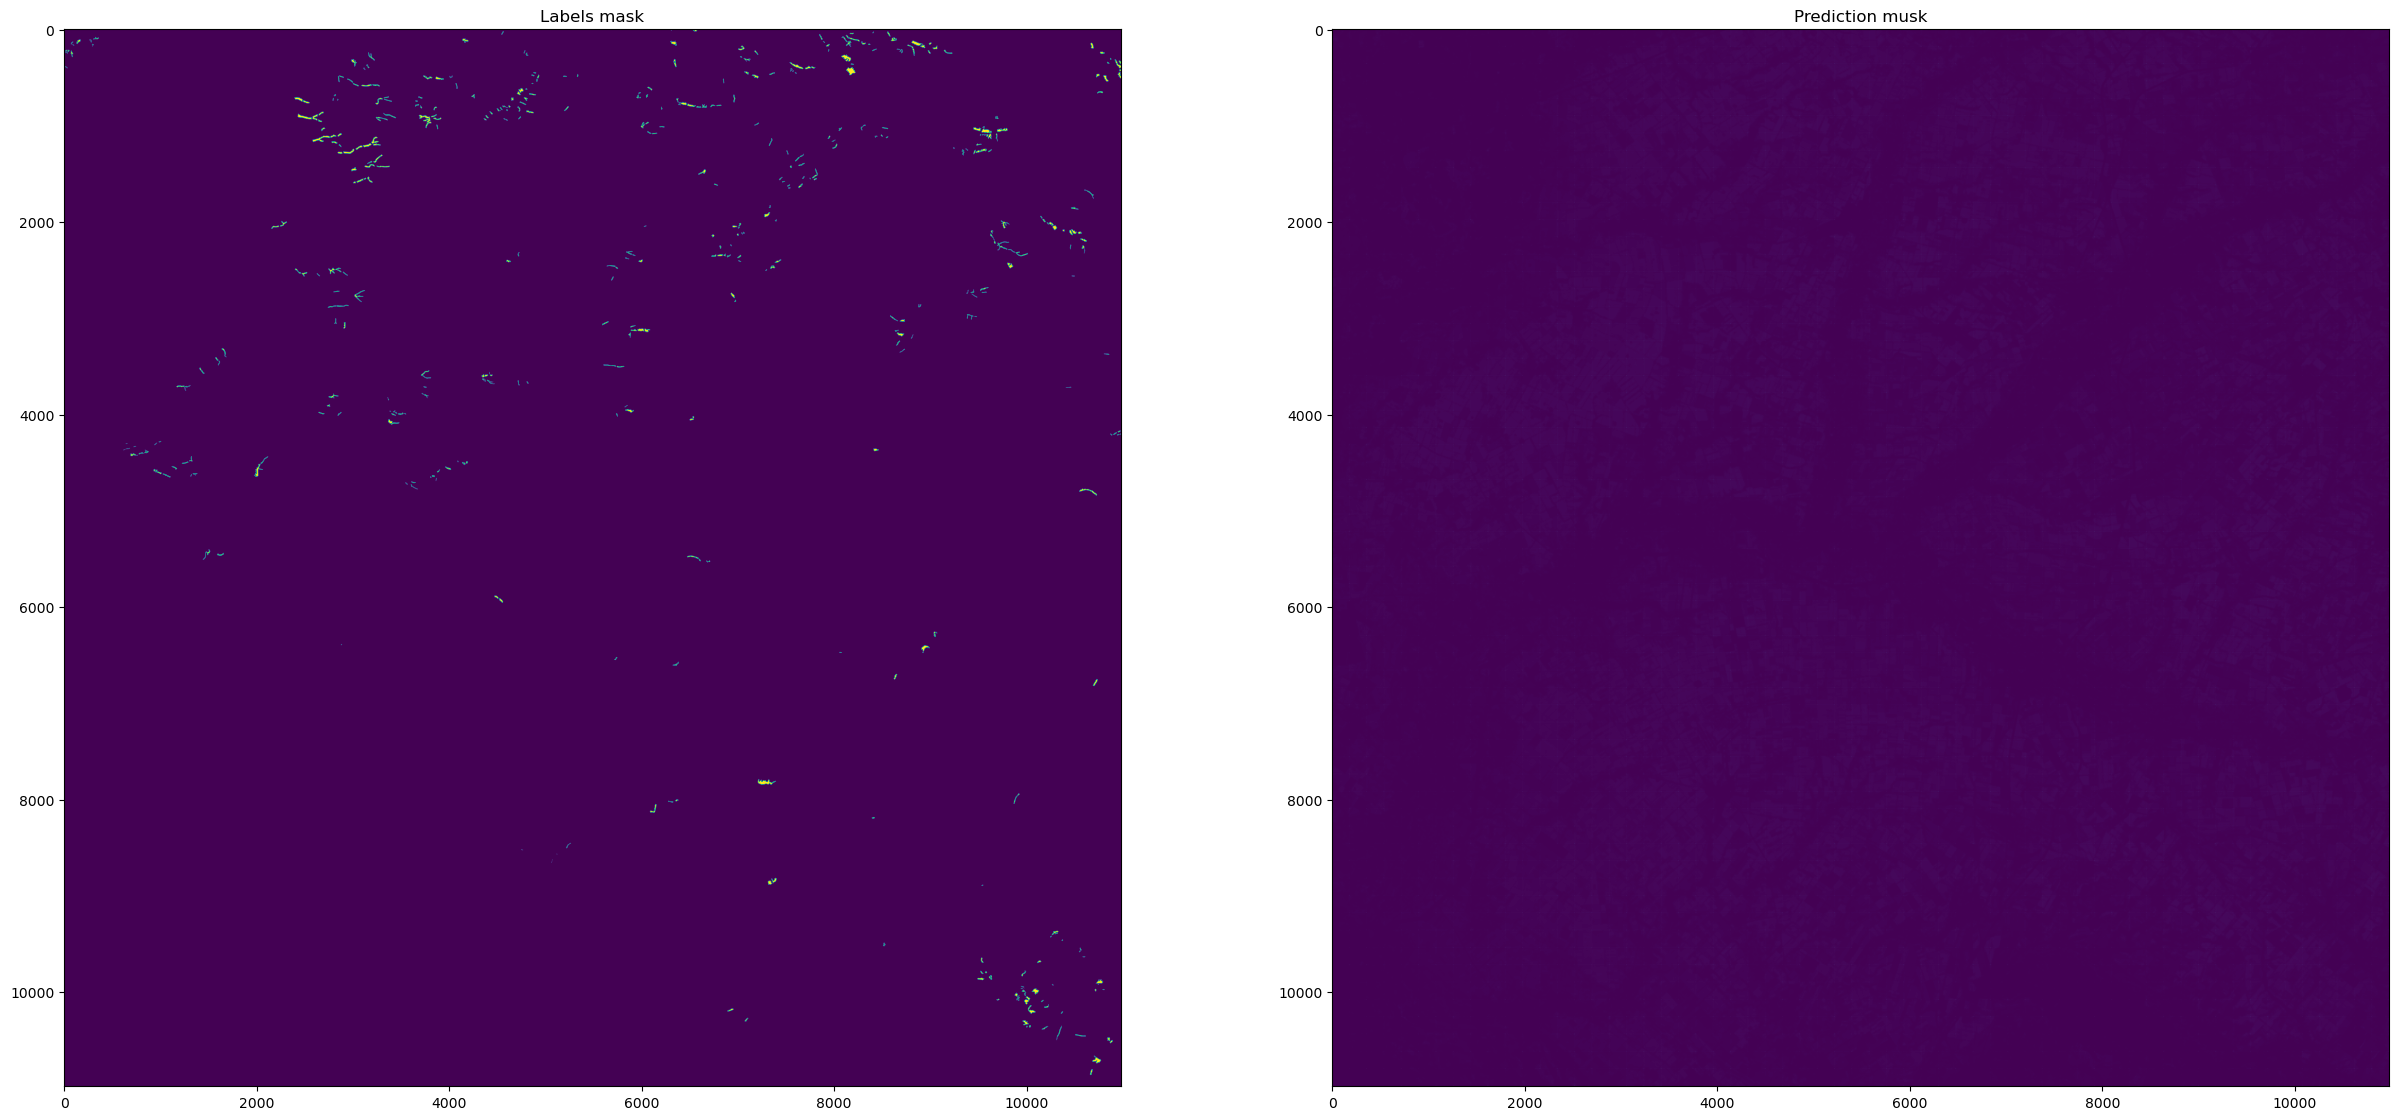

In [53]:
plt.figure(figsize=(30, 15))
plt.subplot(121)
plt.imshow(org_mask)
plt.title("Labels mask")

plt.subplot(122)
plt.imshow(full_predict_mask)
plt.title("Prediction musk")


In [49]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({"count": 1})
with rasterio.open("../prediction.jp2", "w", **bin_mask_meta) as dst:
    dst.write(full_predict_mask[0, ...] * 255, 1)
